# **Loan Program Analysis**



> **Author:** C. Kataki

> **Date:** 16/06/2024





# Preamble


This code is designed to analyze the impact of the Paycheck Protection Program (PPP) and Economic Injury Disaster Loan (EIDL) program in the United States, focusing on the distribution of loans across states and their influence on consumer spending. It includes loading and preprocessing relevant datasets, conducting exploratory data analysis to visualize loan amounts by state, and normalizing the data to account for regional differences. The data is aggregated by state and industry and combined with census data for a thorough overview. Visualization tools like heat maps are employed to identify areas with substantial financial support. Lastly, the relationship between financial support and consumer spending trends is analyzed, providing insights into the effectiveness of these programs during the pandemic.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd

# Load Data

In [ ]:
# Load PPP DataFrame
ppp_data = pd.read_csv('final_combined_ppp_0.1.csv') # The code to create this can be found in the sampled_ppp_loans_df.py file

# Load EIDL DataFrame
eidl_data = pd.read_csv('combined_eidl_data_0.2.csv') # The code to create this can be found in the sampled_eidl_data.py file

# Load Census Data
census_data = pd.read_csv('ABSCS2021.AB2100CSA01-Data.csv') # This takes longer to load compared to the others..

# Remove the first row, as it contains descriptions
census_data = census_data.iloc[1:]

# Clean Data

In [ ]:
# Remove the ghost column 'Unnamed: 21' added from the csv
census_data = census_data.drop(columns=['Unnamed: 21'])

In [ ]:
# Add an empty NAICS column to the EIDL DataFrame
eidl_data['NAICS'] = ''

# Reorder columns in both DataFrame in order to match with the Task 2
ppp_data = ppp_data[['Date', 'Loan', 'State', 'LoanProgram', 'NAICS']]
eidl_data = eidl_data[['Date', 'Loan', 'State', 'LoanProgram', 'NAICS']]

In [ ]:
# Reset the index and adjust to start from 1
ppp_data.reset_index(drop=True, inplace=True)
ppp_data.index = ppp_data.index + 1

eidl_data.reset_index(drop=True, inplace=True)
eidl_data.index = eidl_data.index + 1

# Set the index name
ppp_data.index.name = 'Index'
eidl_data.index.name = 'Index'

In [ ]:
# Display the first few rows to verify changes
print("PPP DataFrame:")
print(ppp_data.head())
print()
print("EIDL DataFrame:")
print(eidl_data.head())

PPP DataFrame:
             Date       Loan State LoanProgram NAICS
Index                                               
1      2021-04-08  1003600.0    WI         PPP    33
2      2020-04-07   423985.0    MO         PPP    31
3      2020-04-10  3771000.0    WI         PPP    52
4      2021-02-06   195445.0    NY         PPP    55
5      2020-04-15   237300.0    PA         PPP    42

EIDL DataFrame:
             Date      Loan State LoanProgram NAICS
Index                                              
1      2020-05-30    1400.0    GA        EIDL      
2      2020-05-20  144200.0    ND        EIDL      
3      2020-05-25   81200.0    CA        EIDL      
4      2020-05-30  150000.0    WI        EIDL      
5      2020-06-05    3300.0    IL        EIDL      


In [ ]:
# Calculate the percentage of NaN values in each column
nan_percentages_ppp = ppp_data.isna().mean() * 100
nan_percentages_eidl = eidl_data.isna().mean() * 100

# Combine the NaN percentages into a single DataFrame
nan_percentages = pd.DataFrame({
    'PPP NaN %': nan_percentages_ppp,
    'EIDL NaN %': nan_percentages_eidl
}).reset_index().rename(columns={'index': 'Column'})

print(nan_percentages)

        Column  PPP NaN %  EIDL NaN %
0         Date   0.000000    0.000000
1         Loan   0.000000    0.001062
2        State   0.001395    0.000000
3  LoanProgram   0.000000    0.000000
4        NAICS   0.000000    0.000000


In [ ]:
# Drop the rows with missing values
filtered_ppp_data = ppp_data.dropna()
filtered_eidl_data = eidl_data.dropna()

In [ ]:
# Get the number of rows (observations) in the PPP DataFrame
num_rows_ppp = filtered_ppp_data.shape[0]
print(f"Number of observations (rows) in the PPP DataFrame: {num_rows_ppp}")

# Get the number of rows (observations) in the EIDL DataFrame
num_rows = filtered_eidl_data.shape[0]
print(f"Number of observations (rows) in the EIDL DataFrame: {num_rows}")

Number of observations (rows) in the PPP DataFrame: 1146813
Number of observations (rows) in the EIDL DataFrame: 753248


# Analyze Data

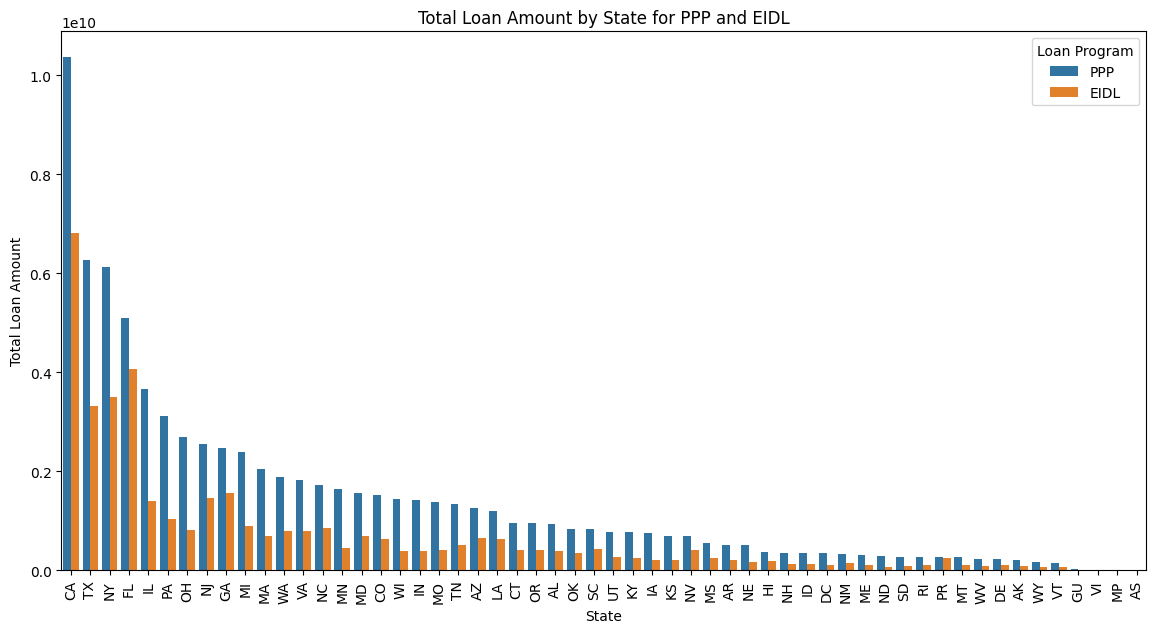

In [ ]:
# Calculate the total loan amount for each state in the PPP program
ppp_total_by_state = filtered_ppp_data.groupby('State')['Loan'].sum().reset_index().rename(columns={'Loan': 'PPP_Total_Loan'})

# Calculate the total loan amount for each state in the EIDL program
eidl_total_by_state = filtered_eidl_data.groupby('State')['Loan'].sum().reset_index().rename(columns={'Loan': 'EIDL_Total_Loan'})

# Merge the results to get the total loan amount by state for both programs
combined_total_by_state = pd.merge(ppp_total_by_state, eidl_total_by_state, on='State', how='outer').fillna(0)

# Convert the DataFrame to long format
combined_total_by_state = pd.melt(combined_total_by_state, id_vars='State', value_vars=['PPP_Total_Loan', 'EIDL_Total_Loan'], var_name='Program', value_name='Total_Loan')

# Plot the combined total loan amounts by state
plt.figure(figsize=(14, 7))
sns.barplot(x='State', y='Total_Loan', hue='Program', data=combined_total_by_state, errorbar=None, estimator=sum, order=combined_total_by_state.sort_values('Total_Loan', ascending=False)['State'].unique())

plt.title('Total Loan Amount by State for PPP and EIDL')
plt.xlabel('State')
plt.ylabel('Total Loan Amount')
plt.xticks(rotation=90)

# Customize the legend
new_labels = ['PPP', 'EIDL']
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, new_labels, title='Loan Program')

plt.show()

In [ ]:
# Concatenate the DataFrames
combined_df = pd.concat([filtered_ppp_data, filtered_eidl_data] )

# Reset the index to ensure consecutive numbering
combined_df.reset_index(drop=True, inplace=True)
combined_df.index = combined_df.index + 1
combined_df.index.name = 'Index'

# Display the combined DataFrame
combined_df

,Date,Loan,State,LoanProgram,NAICS
Index,,,,,
1,2021-04-08,1003600.0,WI,PPP,33
2,2020-04-07,423985.0,MO,PPP,31
3,2020-04-10,3771000.0,WI,PPP,52
4,2021-02-06,195445.0,NY,PPP,55
5,2020-04-15,237300.0,PA,PPP,42
...,...,...,...,...,...
1900057,2020-08-07,123100.0,NY,EIDL,
1900058,2020-10-02,84300.0,IN,EIDL,
1900059,2020-08-10,10800.0,NC,EIDL,


In [ ]:
#Aggregate the Number of Loans and the Total Loan Amount by State and NAICS
aggregated_loan_data = combined_df.groupby(['State', 'NAICS'])['Loan'].agg(['count', 'sum']).reset_index()

# Rename the columns
aggregated_loan_data.columns = ['State', 'NAICS', 'Number_of_Loans', 'Total_Loan_Amount']

# Display the results
aggregated_loan_data.head()

,State,NAICS,Number_of_Loans,Total_Loan_Amount
0,AK,,1634,89594100.00
1,AK,11,400,15061538.32
2,AK,21,18,3220185.60
3,AK,22,2,499216.91
4,AK,23,269,31951277.41


In [ ]:
state_dict = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA",
    "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "District of Columbia": "DC",
    "Florida": "FL", "Georgia": "GA", "Guam": "GU", "Hawaii": "HI", "Idaho": "ID",
    "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY",
    "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI",
    "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE",
    "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
    "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR",
    "Pennsylvania": "PA", "Puerto Rico": "PR", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT",
    "Virginia": "VA", "Virgin Islands": "VI", "Washington": "WA", "West Virginia": "WV",
    "Wisconsin": "WI", "Wyoming": "WY"
}

# Convert the NAME column using the dictionary
census_data['STATE'] = census_data['NAME'].map(state_dict)

# Display the updated DataFrame
census_data.head()

,GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,SEX,SEX_LABEL,ETH_GROUP,ETH_GROUP_LABEL,RACE_GROUP,RACE_GROUP_LABEL,...,YEAR,FIRMPDEMP,RCPPDEMP,EMP,PAYANN,FIRMPDEMP_S,RCPPDEMP_S,EMP_S,PAYANN_S,STATE
1,0400000US01,Alabama,00,Total for all sectors,001,Total,001,Total,00,Total,...,2021,70218,W,1646723,83863653,0.7,S,1.5,3.3,AL
2,0400000US01,Alabama,00,Total for all sectors,002,Female,001,Total,00,Total,...,2021,12234,W,131001,5102506,5.4,S,14.4,11.6,AL
3,0400000US01,Alabama,00,Total for all sectors,003,Male,001,Total,00,Total,...,2021,45451,W,697919,33959997,2.1,S,3.4,7.8,AL
4,0400000US01,Alabama,00,Total for all sectors,004,Equally male/female,001,Total,00,Total,...,2021,7977,W,69855,2601361,5.3,S,16.0,23.5,AL
5,0400000US01,Alabama,00,Total for all sectors,001,Total,020,Hispanic,00,Total,...,2021,1177,U,14650,572673,14.3,S,32.0,14.7,AL


In [ ]:
# The "EMP" column has a weird format (e.g. 500 to 999 employees)...
# Function to convert employee ranges to midpoints
def convert_emp_to_numeric(emp):
    if pd.isna(emp):
        return np.nan
    emp = str(emp).replace(',', '')  # Remove commas and ensure emp is a string
    if 'to' in emp:
        numbers = [int(n) for n in emp.split() if n.isdigit()]
        return sum(numbers) // len(numbers)
    elif 'or' in emp: # '100,000 employees or more'
        return 100000
    try:
        return int(emp)
    except ValueError:
        return np.nan  # For invalid data

# Apply the function to the EMP column
census_data['EMP_numeric'] = census_data['EMP'].apply(convert_emp_to_numeric)

# Convert FIRMPDEMP to numeric, coerce errors to NaN
census_data['FIRMPDEMP'] = pd.to_numeric(census_data['FIRMPDEMP'], errors='coerce')

# Keeping PAYANN for Michigan and North Carolina comparison later
census_data['PAYANN'] = pd.to_numeric(census_data['PAYANN'], errors='coerce') # 'S' appears in 65k cases

# Group by 'STATE' and 'NAICS2017', then aggregate the sum for 'EMP_numeric', 'FIRMPDEMP' and 'PAYANN'
aggregated_census_data = census_data.groupby(['STATE', 'NAICS2017'])[['EMP_numeric', 'FIRMPDEMP', 'PAYANN']].sum().reset_index()

# Display the aggregated data
aggregated_census_data.head()

,STATE,NAICS2017,EMP_numeric,FIRMPDEMP,PAYANN
0,AK,00,2484216,261379.0,145742621.0
1,AK,11(660),3182,4135.0,262489.0
2,AK,21,54082,1462.0,9513079.0
3,AK,22,6432,513.0,548542.0
4,AK,23,233654,43607.0,18208722.0


In [ ]:
# NAICS are a bit different in the census dataset
print(census_data['NAICS2017'].unique())

['00' '11(660)' '21' '22' '23' '31-33' '42' '44-45' '48-49(661)' '51'
 '52(662)' '53' '54' '55' '56' '61' '62' '71' '72' '81(663)' '99']


In [ ]:
# Will add a helper column to the aggregated data to facilitate the merge
# Dictionary to map simple NAICS codes to 'complex' NAICS codes for merging purposes
naics_helper_dict = {
    '11': '11(660)',
    '31': '31-33',
    '32': '31-33',
    '33': '31-33',
    '44': '44-45',
    '45': '44-45',
    '48': '48-49(661)',
    '49': '48-49(661)',
    '52': '52(662)',
    '81': '81(663)'
}

# Function to map a given NAICS code to its 'complex' NAICS code
def map_to_complex_naics(naics):
    complex_naics = naics_helper_dict.get(str(naics))
    if complex_naics is None:
        return str(naics)
    else:
        return complex_naics

# Apply the mapping function to the 'NAICS' column and create a new 'complex_naics' column
aggregated_loan_data['Complex_NAICS'] = aggregated_loan_data['NAICS'].map(map_to_complex_naics)

# Display the updated DataFrame
aggregated_loan_data.head()

,State,NAICS,Number_of_Loans,Total_Loan_Amount,Complex_NAICS
0,AK,,1634,89594100.00,
1,AK,11,400,15061538.32,11(660)
2,AK,21,18,3220185.60,21
3,AK,22,2,499216.91,22
4,AK,23,269,31951277.41,23


In [ ]:
# Merge the total loan amount data with census data
merged_total_loans = aggregated_loan_data.merge(aggregated_census_data, left_on=['State', 'Complex_NAICS'], right_on=['STATE', 'NAICS2017'], how='inner')


# Display the results
merged_total_loans.head()

,State,NAICS,Number_of_Loans,Total_Loan_Amount,Complex_NAICS,STATE,NAICS2017,EMP_numeric,FIRMPDEMP,PAYANN
0,AK,11,400,15061538.32,11(660),AK,11(660),3182,4135.0,262489.0
1,AK,21,18,3220185.60,21,AK,21,54082,1462.0,9513079.0
2,AK,22,2,499216.91,22,AK,22,6432,513.0,548542.0
3,AK,23,269,31951277.41,23,AK,23,233654,43607.0,18208722.0
4,AK,31,18,3534793.39,31-33,AK,31-33,132954,8120.0,7399467.0


In [ ]:
# # Replace NaN with 1 in FIRMPDEMP columns to avoid division by zero
# merged_total_loans['FIRMPDEMP'] = merged_total_loans['FIRMPDEMP'].fillna(1)

# Normalize total loan amount and number of loans by number of employees and number of firms
merged_total_loans['Normalized_Total_Loan_Amount_by_EMP'] = merged_total_loans['Total_Loan_Amount'] / merged_total_loans['EMP_numeric']
merged_total_loans['Normalized_Total_Loan_Amount_by_FIRMPDEMP'] = merged_total_loans['Total_Loan_Amount'] / merged_total_loans['FIRMPDEMP']

merged_total_loans['Normalized_Loan_Count_by_EMP'] = merged_total_loans['Number_of_Loans'] / merged_total_loans['EMP_numeric']
merged_total_loans['Normalized_Loan_Count_by_FIRMPDEMP'] = merged_total_loans['Number_of_Loans'] / merged_total_loans['FIRMPDEMP']

# Normalize payroll by number of employees
merged_total_loans['Normalized_Payroll_by_EMP'] = merged_total_loans['PAYANN'] / merged_total_loans['EMP_numeric']

# Display the results
merged_total_loans.head()


,State,NAICS,Number_of_Loans,Total_Loan_Amount,Complex_NAICS,STATE,NAICS2017,EMP_numeric,FIRMPDEMP,PAYANN,Normalized_Total_Loan_Amount_by_EMP,Normalized_Total_Loan_Amount_by_FIRMPDEMP,Normalized_Loan_Count_by_EMP,Normalized_Loan_Count_by_FIRMPDEMP,Normalized_Payroll_by_EMP
0,AK,11,400,15061538.32,11(660),AK,11(660),3182,4135.0,262489.0,4733.355852,3642.451831,0.125707,0.096735,82.491829
1,AK,21,18,3220185.60,21,AK,21,54082,1462.0,9513079.0,59.542650,2202.589330,0.000333,0.012312,175.901021
2,AK,22,2,499216.91,22,AK,22,6432,513.0,548542.0,77.614569,973.132378,0.000311,0.003899,85.283271
3,AK,23,269,31951277.41,23,AK,23,233654,43607.0,18208722.0,136.746118,732.709827,0.001151,0.006169,77.930282
4,AK,31,18,3534793.39,31-33,AK,31-33,132954,8120.0,7399467.0,26.586589,435.319383,0.000135,0.002217,55.654339


In [ ]:
# Previously we aggregated per state and naics to get the most out of our data and the merge with census
# At this point we will aggregate per state to proceed with the maps

# List of columns to aggregate
columns_to_aggregate = [
    'EMP_numeric',
    'FIRMPDEMP',
    'Total_Loan_Amount',
    'Number_of_Loans',
    'PAYANN',
]

# Group the DataFrame by 'STATE' and sum the specified columns
merged_total_loans = merged_total_loans.groupby('STATE')[columns_to_aggregate].sum().reset_index()

# Normalize total loan amount and number of loans by number of employees and number of firms
merged_total_loans['Normalized_Total_Loan_Amount_by_EMP'] = merged_total_loans['Total_Loan_Amount'] / merged_total_loans['EMP_numeric']
merged_total_loans['Normalized_Total_Loan_Amount_by_FIRMPDEMP'] = merged_total_loans['Total_Loan_Amount'] / merged_total_loans['FIRMPDEMP']

merged_total_loans['Normalized_Loan_Count_by_EMP'] = merged_total_loans['Number_of_Loans'] / merged_total_loans['EMP_numeric']
merged_total_loans['Normalized_Loan_Count_by_FIRMPDEMP'] = merged_total_loans['Number_of_Loans'] / merged_total_loans['FIRMPDEMP']

# Normalize payroll by number of employees
merged_total_loans['Normalized_Payroll_by_EMP'] = merged_total_loans['PAYANN'] / merged_total_loans['EMP_numeric']

# Display the results
merged_total_loans.head()


,STATE,EMP_numeric,FIRMPDEMP,Total_Loan_Amount,Number_of_Loans,PAYANN,Normalized_Total_Loan_Amount_by_EMP,Normalized_Total_Loan_Amount_by_FIRMPDEMP,Normalized_Loan_Count_by_EMP,Normalized_Loan_Count_by_FIRMPDEMP,Normalized_Payroll_by_EMP
0,AK,3416587,228834.0,2.155214e+08,2410,1.343532e+08,63.080905,941.824205,0.000705,0.010532,39.323812
1,AL,26269964,1173667.0,9.279765e+08,16826,9.742516e+08,35.324619,790.664190,0.000641,0.014336,37.086141
2,AR,15363320,957005.0,5.087151e+08,10231,5.999584e+08,33.112317,531.569968,0.000666,0.010691,39.051348
3,AZ,33504891,2239796.0,1.237935e+09,16434,1.551538e+09,36.947894,552.699955,0.000490,0.007337,46.307792
4,CA,195081638,16890402.0,1.021387e+10,124626,1.354040e+10,52.356911,604.714554,0.000639,0.007379,69.408904


# Output Data

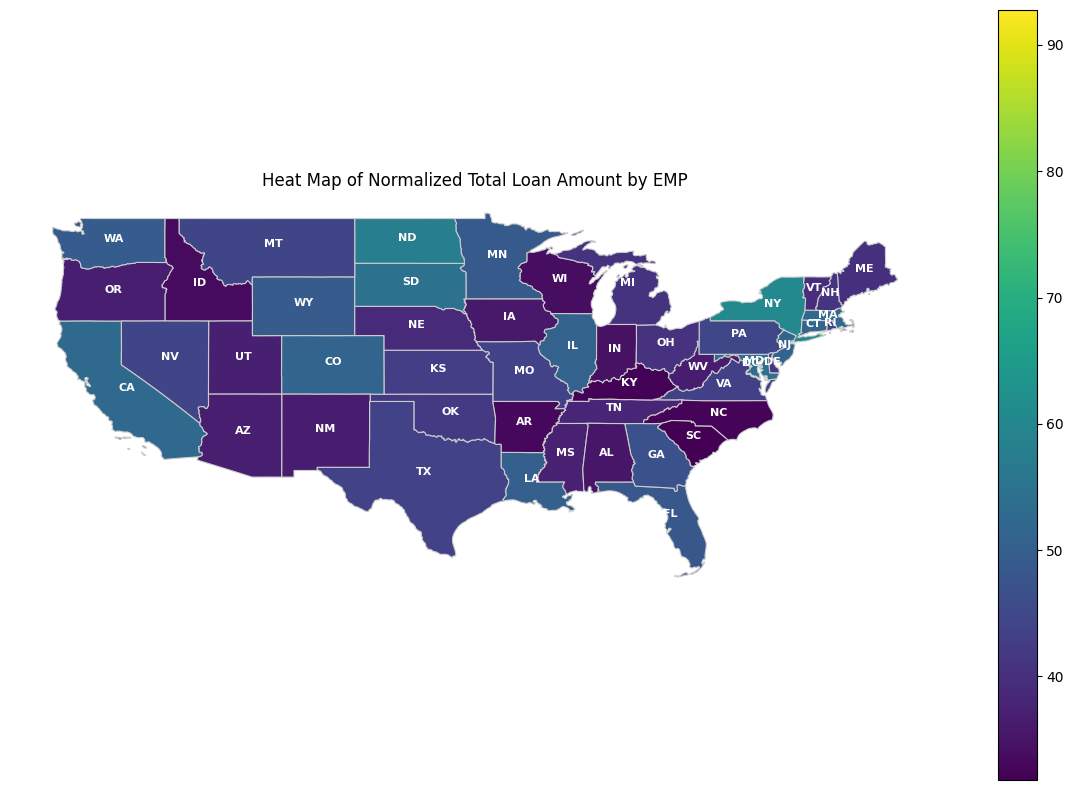

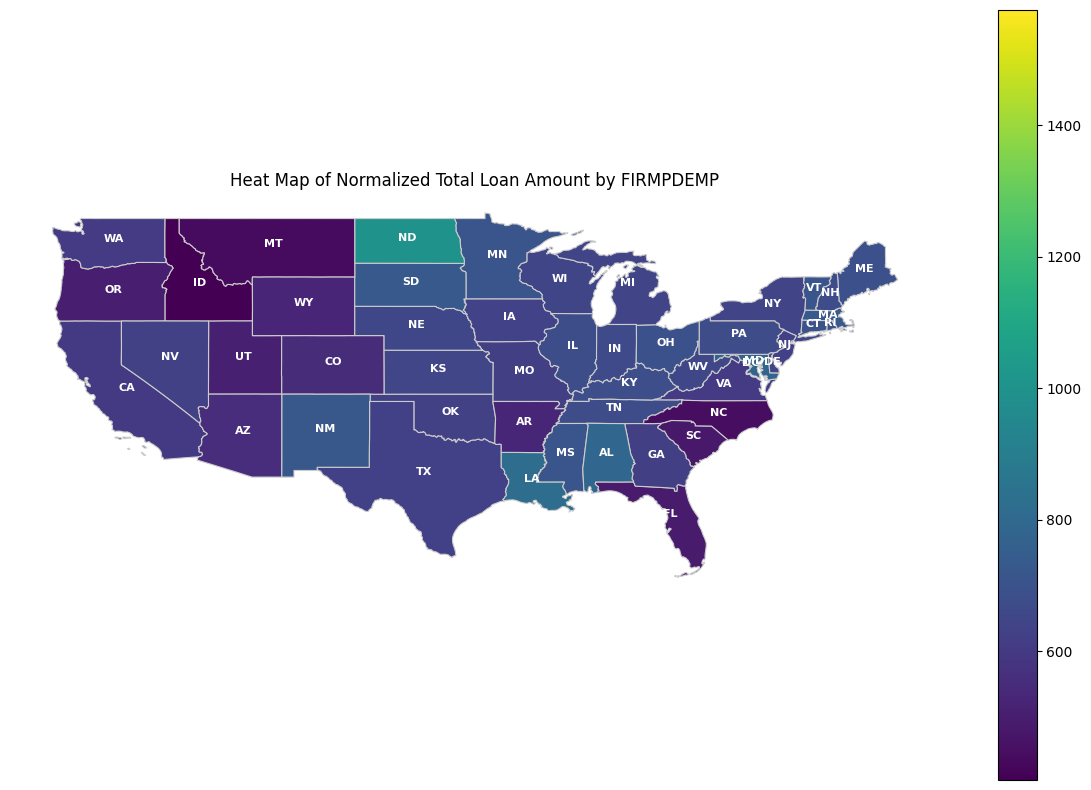

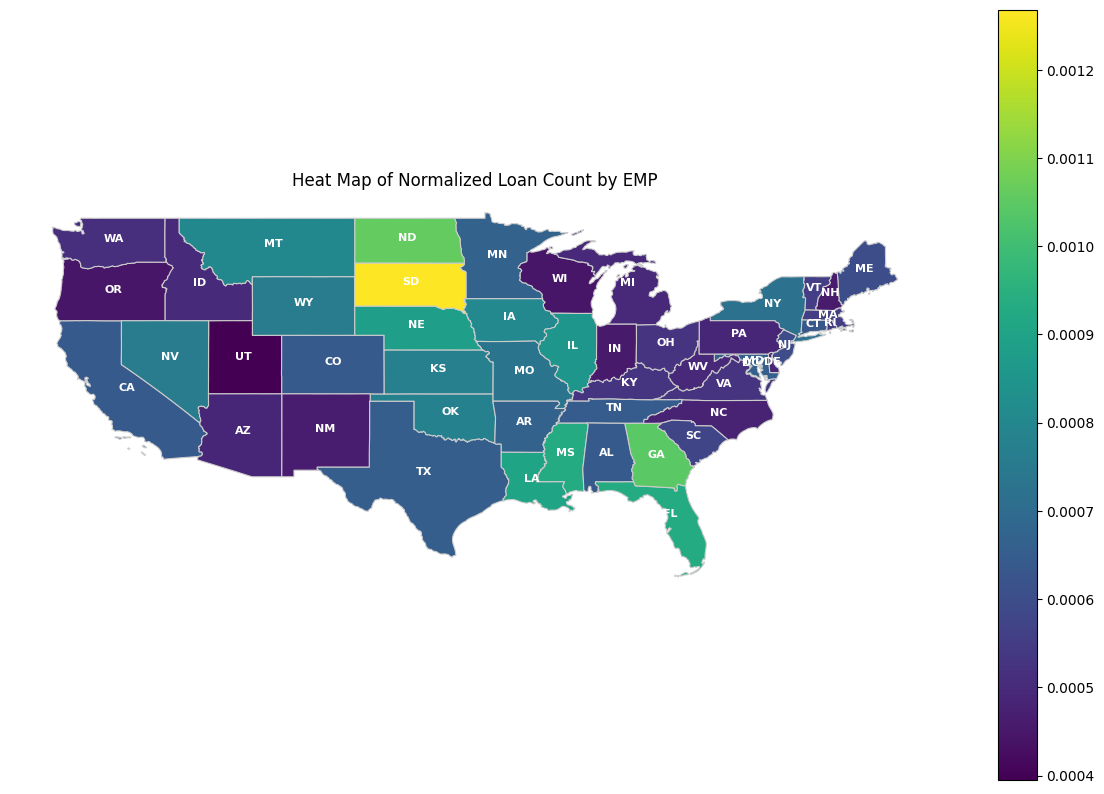

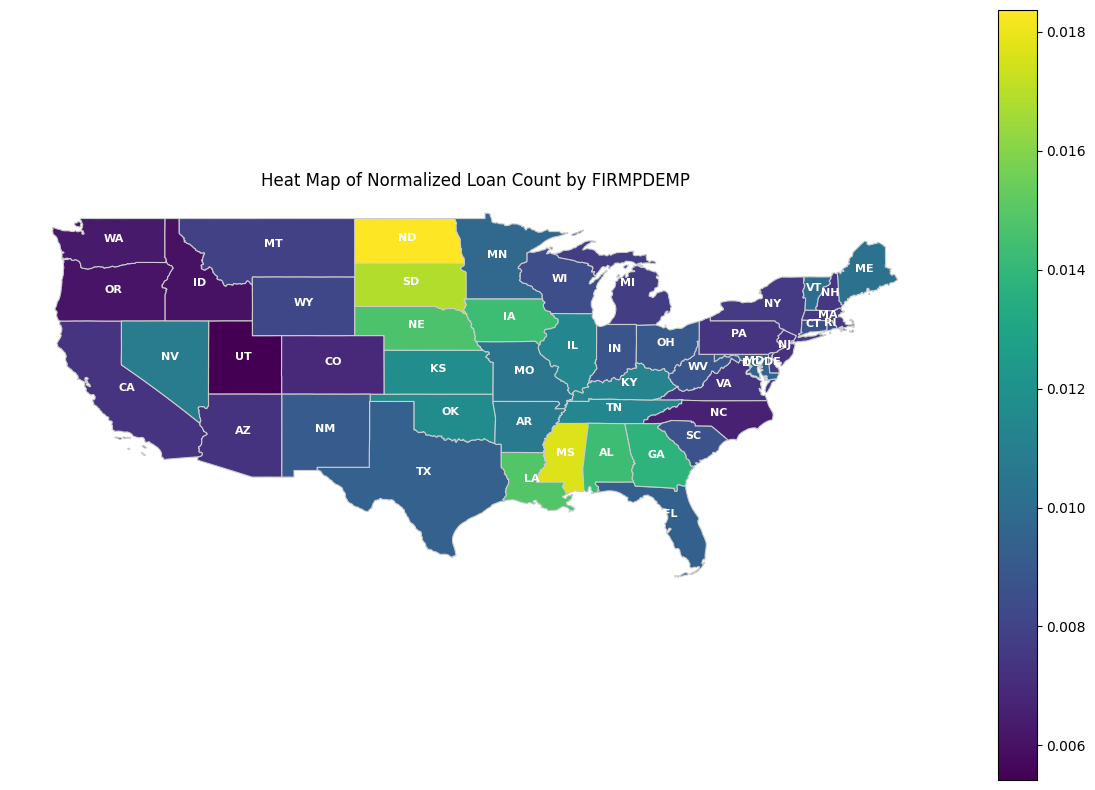

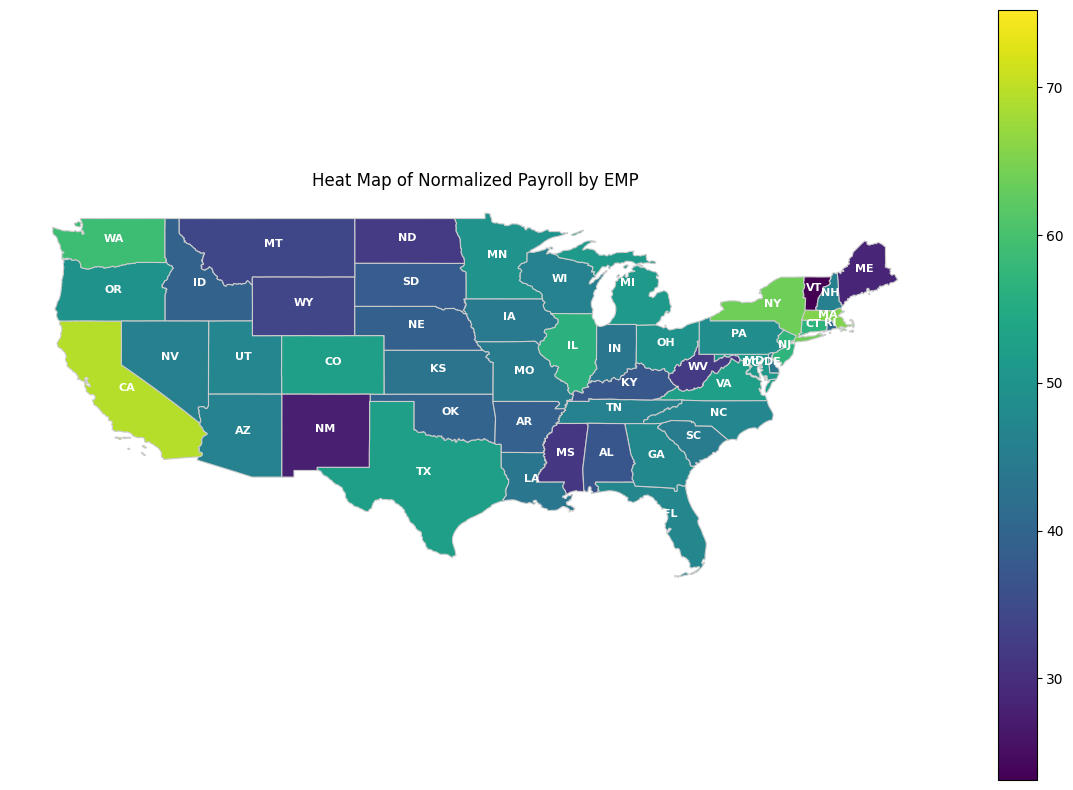

In [ ]:
## Make the map plot

# Path to the shapefiles
shapefile_path = 'cb_2020_us_state_20m.shp'

# Load the US states shapefile
gdf = gpd.read_file(shapefile_path)

# Rename 'STUSPS' to 'State'
gdf = gdf.rename(columns={'STUSPS': 'STATE'})

# Merge the geospatial data with the normalized loan data
# 'STATE' is the common column for merging
merged_gdf = gdf.set_index('STATE').join(merged_total_loans.set_index('STATE'))

# List of columns to plot
columns_to_plot = [
    'Normalized_Total_Loan_Amount_by_EMP',
    'Normalized_Total_Loan_Amount_by_FIRMPDEMP',
    'Normalized_Loan_Count_by_EMP',
    'Normalized_Loan_Count_by_FIRMPDEMP',
    'Normalized_Payroll_by_EMP'
]

# Create heat maps
for column in columns_to_plot:
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    contiguous_usa = merged_gdf[~merged_gdf.index.isin(['AK', 'HI', 'PR'])]  # Exclude Alaska, Hawaii, and Puerto Rico
    contiguous_usa.plot(column=column, cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    ax.set_title(f'Heat Map of {column.replace("_", " ")}')
    ax.axis('off')

    # Add labels to the states
    for idx, row in contiguous_usa.iterrows():
        ax.annotate(text=idx, xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                    horizontalalignment='center', fontsize=8, color='white', weight='bold')

plt.show()

In [ ]:
# Michigan and North Carolina comparisons.

# Group the combined loan data by State and sum the Loan amounts for each State
aggregated_loan_data_state = combined_df.groupby('State')['Loan'].sum().reset_index()
# Rename the columns for clarity
aggregated_loan_data_state.columns = ['State', 'Total_Loan_Amount']

# Extract the total loan amount for Michigan (MI)
michigan_loan_amount = aggregated_loan_data_state[aggregated_loan_data_state['State'] == 'MI']['Total_Loan_Amount'].values[0]
# Extract the total loan amount for North Carolina (NC)
north_carolina_loan_amount = aggregated_loan_data_state[aggregated_loan_data_state['State'] == 'NC']['Total_Loan_Amount'].values[0]
# Print the loan amounts for both states and calculate the percentage difference
print(f"North Carolina loan amount: {north_carolina_loan_amount}. Michigan loan amount: {michigan_loan_amount} ({100*(michigan_loan_amount/north_carolina_loan_amount - 1):.2f}% higher). ")

# Group the census data by STATE and sum the annual payroll (PAYANN) for each State
aggregated_census_data_state = aggregated_census_data.groupby('STATE')['PAYANN'].sum().reset_index()
# Rename the columns for clarity
aggregated_census_data_state.columns = ['State', 'Total_Annual_Payroll']

# Extract the total annual payroll for Michigan (MI)
michigan_annual_payrolls = aggregated_census_data_state[aggregated_census_data_state['State'] == 'MI']['Total_Annual_Payroll'].values[0]
# Extract the total annual payroll for North Carolina (NC)
north_carolina_annual_payrolls = aggregated_census_data_state[aggregated_census_data_state['State'] == 'NC']['Total_Annual_Payroll'].values[0]
# Print the annual payrolls for both states and calculate the percentage difference
print(f"North Carolina annual payrolls: {north_carolina_annual_payrolls}. Michigan annual payrolls: {michigan_annual_payrolls} ({100*(michigan_annual_payrolls/north_carolina_annual_payrolls - 1):.2f}% higher). ")

# Filter the merged total loans data for Michigan (MI) and North Carolina (NC)
merged_total_loans[merged_total_loans['STATE'].isin(['MI', 'NC'])]

North Carolina loan amount: 2573941524.33. Michigan loan amount: 3303045866.13 (28.33% higher). 
North Carolina annual payrolls: 3647018221.0. Michigan annual payrolls: 4172181579.0 (14.40% higher). 


,STATE,EMP_numeric,FIRMPDEMP,Total_Loan_Amount,Number_of_Loans,PAYANN,Normalized_Total_Loan_Amount_by_EMP,Normalized_Total_Loan_Amount_by_FIRMPDEMP,Normalized_Loan_Count_by_EMP,Normalized_Loan_Count_by_FIRMPDEMP,Normalized_Payroll_by_EMP
22,MI,58305498,3709090.0,2.377121e+09,28647,2.986231e+09,40.770097,640.890572,0.000491,0.007723,51.216975
27,NC,53111780,3851459.0,1.715081e+09,25487,2.493090e+09,32.291922,445.306953,0.000480,0.006617,46.940427
